In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import time
from IPython import display

import cv2

In [217]:
CWD = Path.cwd()
CHECKPOINT_DIR = CWD/'checkpoints'
GENERATED_IMAGES_DIR = CWD/'generated_images'
SINGLE_IMAGE_DIR = GENERATED_IMAGES_DIR/'single'
COLLAGE_DIR = GENERATED_IMAGES_DIR/'collage'
DATASET_PATH = Path(r'E:\datasets\gan-getting-started')
FOLDERS_TO_SETUP = [
	CHECKPOINT_DIR,
	GENERATED_IMAGES_DIR,
	SINGLE_IMAGE_DIR,
	COLLAGE_DIR
]

In [3]:
def mkdir(path):
	path.mkdir(exist_ok=True)

In [4]:
def setup_folders(paths: list):
	for path in paths:
		mkdir(path)

#### data preparation

In [6]:
IMAGE_SHAPE = (64, 64, 3)
BATCHSIZE = 64

In [7]:
def normalize_images(images):
	return (images-127.5)/127.5

In [148]:
def denormalize_images(images):
	return np.array(((images*127.5)+127.5), dtype='uint8')

In [9]:
def prepare_images():
	images = np.array([plt.imread(image) for image in (DATASET_PATH/'monet_jpg').glob('*')], dtype='float32')
	assert images.shape == (images.shape[0], 256, 256, 3), 'input images have the wrong dimensions!'
	
	resized_images = np.array([cv2.resize(image, [64, 64], interpolation=cv2.INTER_AREA) for image in images])
	normalized_images = normalize_images(resized_images)
	assert normalized_images.shape[1:] == (64, 64, 3), 'output images have the wrong dimensions!'
	
	return normalized_images

In [10]:
images = prepare_images()
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(images.shape[0]).batch(BATCHSIZE)

#### model building

In [11]:
from tensorflow.keras import layers

In [12]:
def wasserstein_loss(y_true, y_pred):
	tf.keras.backend.mean(y_true*y_pred)

In [13]:
def conv_block(x, n_filters, kernel_size=(3, 3), strides=(2, 2), padding='same'):
	x = layers.Conv2D(n_filters, kernel_size, strides, padding)(x)
	x = layers.LeakyReLU(0.1)(x)
	x = layers.Dropout(0.3)(x)
	return x

In [14]:
def transposed_conv_block(x, n_filters, kernel_size=(3, 3), strides=(2, 2), padding=('same')):
	x = layers.Conv2DTranspose(n_filters, kernel_size, strides, padding, use_bias=False)(x)
	x = layers.BatchNormalization()(x)
	x = layers.LeakyReLU(0.1)(x)
	return x

In [212]:
class Generator():
	def __init__(self, input_size):
		self.input_size = input_size
		self.optimizer = tf.keras.optimizers.Adam(2e-4, 0.5, 0.9)
		self.model = self.build()
		
	def __call__(self, inputs):
		return self.model(inputs)
	
	def build(self):
		inputs = layers.Input(self.input_size)

		x = layers.Dense(8*8*128)(inputs)
		x = layers.BatchNormalization()(x)
		x = layers.LeakyReLU(0.1)(x)

		x = layers.Reshape((8, 8, 128))(x)

		x = transposed_conv_block(x, 128)
		x = transposed_conv_block(x, 128, strides=(1, 1))
		x = transposed_conv_block(x, 64)

		outputs = transposed_conv_block(x, 3)
		assert outputs.shape == [None, 64, 64, 3], f'output tensor\'s shapes are wrong, {outputs.shape}'

		model = tf.keras.Model(inputs, outputs, name='generator')

		return model
	
	def compute_loss(self, fake_image):
		return -tf.reduce_mean(fake_image)

In [94]:
class Critic():
	def __init__(self, input_size):
		self.input_size = input_size
		self.optimizer = tf.keras.optimizers.Adam(2e-4, 0.5, 0.9)
		self.model = self.build()
		# self.model.compile(optimizer=self.optimizer, loss=self.compute_loss)
		
	def __call__(self, inputs):
		return self.model(inputs)
	
	def build(self):
		inputs = layers.Input(self.input_size)

		x = conv_block(inputs, 64)
		x = conv_block(inputs, 128)
		x = conv_block(x, 256)

		x = layers.Flatten()(x)
		x = layers.Dropout(0.3)(x)
		outputs = layers.Dense(1)(x)

		model = tf.keras.Model(inputs, outputs, name='critic')

		return model
	
	def compute_loss(self, real_image, fake_image):
		real_loss = tf.reduce_mean(real_image)  # uhhh.. check dis maybe
		fake_loss = tf.reduce_mean(fake_image)
		return fake_loss - real_loss

In [211]:
class WGAN(tf.keras.Model):
	def __init__(self, generator, critic, latent_dim, batchsize=BATCHSIZE, critic_extra_steps=3, alpha=1e-4, beta1=0, beta2=0.9, lambd=10):
		super().__init__()
		self.generator = generator
		self.critic = critic
		self.optimizer = tf.keras.optimizers.Adam(alpha, beta1, beta2)
		self.latent_dim = latent_dim
		self.critic_extra_steps = critic_extra_steps
		self.batchsize = BATCHSIZE
		self.lambd = lambd

	def compute_gradient_penalty(self, generated_images, real_images):
		epsilon = tf.random.uniform((tf.shape(real_images)[0], 1, 1, 1), 0, 1)
		interpolated_generated_images = epsilon * real_images + (1-epsilon) * generated_images

		with tf.GradientTape() as gp_tape:
			gp_tape.watch(interpolated_generated_images)
			prediction = critic(interpolated_generated_images)

		grads = gp_tape.gradient(prediction, interpolated_generated_images)
		
		# norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3)))

		# in the official paper the formula suggested to be only used on singular examples, therefore omit batchnormalization. This might be an alternative
		norm = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(grads), axis=(1, 2, 3))))
		gradient_penalty = self.lambd * tf.square(norm - 1)

		return gradient_penalty

	def train_step(self, images):
		for _ in range(self.critic_extra_steps):
			noise = tf.random.normal(shape=(tf.shape(images)[0], self.latent_dim))
			
			with tf.GradientTape() as tape:
				generated_images = self.generator(noise)
				fake_predictions = self.critic(generated_images)
				real_predictions = self.critic(images)
			
				c_cost = self.critic.compute_loss(real_predictions, fake_predictions)
				gradient_penalty = self.compute_gradient_penalty(generated_images, images)
				c_loss = c_cost + gradient_penalty
		
			c_gradient = tape.gradient(c_loss, self.critic.model.trainable_variables)
			self.critic.optimizer.apply_gradients(zip(c_gradient, self.critic.model.trainable_variables))

		noise = tf.random.normal((self.batchsize, self.latent_dim))
		
		with tf.GradientTape() as tape:
			generated_images = self.generator(noise)
			fake_predictions = self.critic(generated_images)
			g_loss = self.generator.compute_loss(fake_predictions)
		
		g_gradient = tape.gradient(g_loss, self.generator.model.trainable_variables)
		self.generator.optimizer.apply_gradients(zip(g_gradient, self.generator.model.trainable_variables))
		
		return {'c_loss': c_loss, 'g_loss': g_loss}

In [255]:
class GANMonitor(tf.keras.callbacks.Callback):
	def __init__(self, n_images=16, latent_dim=100):
		self.n_images = n_images
		self.latent_dim = latent_dim
		
	def on_epoch_end(self, epoch, logs=None):
		noise = tf.random.normal((self.n_images, self.latent_dim))
		generated_images = self.model.generator(noise)
		generated_images = denormalize_images(generated_images)
	
		# display.clear_output(True)
		
		for i in range(self.n_images):
			plt.subplot(4, 4, i+1)
			plt.imshow(generated_images[i])
			plt.axis('off')
			
		if epoch % 25 == 0:
			checkpoint.save(CHECKPOINT_DIR/'checkpoint')
		
		if epoch % 10 == 0:
			plt.savefig(GENERATED_IMAGES_DIR/f'image_at_epoch_{epoch}.png', format='png', dpi=300)
			
		plt.show

#### training

In [228]:
LATENT_DIM = 100

In [256]:
gan_monitor = GANMonitor()
generator = Generator(LATENT_DIM)
critic = Critic(IMAGE_SHAPE)
checkpoint = tf.train.Checkpoint(
	generator_optimizer=generator.optimizer,
	critic_optimizer=critic.optimizer,
	generator=generator.model,
	critic=critic.model
)

In [257]:
wgan = WGAN(generator, critic, LATENT_DIM)
wgan.compile()

Epoch 1/5
5/5 [==============================] - 5s 622ms/step - c_loss: -7.5522 - g_loss: -0.3561
Epoch 2/5
5/5 [==============================] - 1s 248ms/step - c_loss: -63.0427 - g_loss: -6.8239
Epoch 3/5
5/5 [==============================] - 1s 245ms/step - c_loss: -92.7030 - g_loss: -6.3681
Epoch 4/5
5/5 [==============================] - 1s 246ms/step - c_loss: -107.9310 - g_loss: 4.3660
Epoch 5/5
5/5 [==============================] - 1s 262ms/step - c_loss: -95.6991 - g_loss: -5.8327


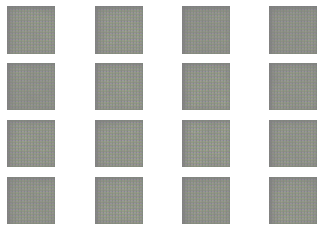

In [258]:
EPOCHS = 5
setup_folders(FOLDERS_TO_SETUP)
wgan.fit(train_dataset, shuffle=True, batch_size=BATCHSIZE, epochs=EPOCHS, callbacks=[gan_monitor])

In [223]:
wgan.history.history.keys()

dict_keys(['c_loss', 'g_loss'])

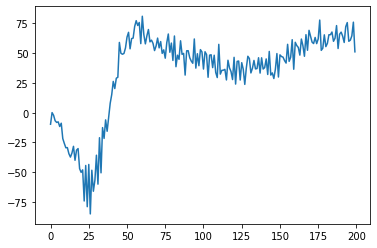

In [225]:
plt.plot(wgan.history.history['g_loss'])

#### refrences
http://modelai.gettysburg.edu/2020/wgan/Resources/Lesson5/WGAN-GP.pdf  
https://keras.io/examples/generative/wgan_gp/  
https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py  
https://developers.google.com/machine-learning/gan/loss  
https://www.youtube.com/watch?v=pG0QZ7OddX4  
https://distill.pub/2016/deconv-checkerboard/  